# Milestone 2

## 0: Loading Data

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score


In [14]:
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

Our project involves data from the US Securities and Exchange Commission (SEC) Form 13F. From `sec.gov`:

*Form 13F was adopted pursuant to statutory directive designed to provide the Commission with data from larger managers about their investment activities and holdings. The FORM 13F data sets are extracted from EDGAR FORM 13F XML ﬁlings in a ﬂat ﬁle format to assist users in constructing the data for analysis.*

*Note that the data includes FORM 13F EDGAR information "as filed" in EDGAR document submissions including amendments of prior submissions. Data in this submitted form may contain redundancies, inconsistencies, and discrepancies relative to prior submissions and other publication formats*

For our project, we will analyze two tables, `INFOTABLE` and `SUMMARYPAGE`. 

`INFOTABLE` has the following columns:

In [15]:
%matplotlib inline

if os.path.exists("infotable_dataset.csv"):
    infotable_dataset = pd.read_csv("infotable_dataset.csv")
else:
    file_paths = [
        'INFOTABLE_2023q4.tsv',
        'INFOTABLE_2023q3.tsv'
    ]

    dataframes = []

    for file_path in file_paths:
        year_quarter = file_path.split('_')[1].split('.')[0]
        year = int(year_quarter[:4])
        quarter = int(year_quarter[4:].replace("q", ""))
        df = pd.read_csv(file_path, delimiter='\t')
        df.rename(columns={'ACCESSION_NUMBER': 'investor'}, inplace=True)

        if quarter == 1:
            df['timestamp'] = pd.Timestamp(year, 1, 1)  # Q1: January 1st
        elif quarter == 2:
            df['timestamp'] = pd.Timestamp(year, 4, 1)  # Q2: April 1st
        elif quarter == 3:
            df['timestamp'] = pd.Timestamp(year, 7, 1)  # Q3: July 1st
        elif quarter == 4:
            df['timestamp'] = pd.Timestamp(year, 10, 1)  # Q4: October 1st

        dataframes.append(df)

    infotable_dataset = pd.concat(dataframes, ignore_index=True)

    infotable_dataset.to_csv("infotable_dataset.csv", index=False)
    
print(infotable_dataset.head())

C:\Users\Aditya Saxena\AppData\Local\Temp\ipykernel_6744\3518187512.py:4: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  infotable_dataset = pd.read_csv("infotable_dataset.csv")


               investor  INFOTABLE_SK                NAMEOFISSUER  \
0  0000051762-23-000005      94734396         ABBOTT LABORATORIES   
1  0000051762-23-000005      94734397                  ABBVIE INC   
2  0000051762-23-000005      94734398                   ADOBE INC   
3  0000051762-23-000005      94734399  ADVANCED MICRO DEVICES INC   
4  0000051762-23-000005      94734400             AES CORPORATION   

  TITLEOFCLASS      CUSIP          FIGI     VALUE  SSHPRNAMT SSHPRNAMTTYPE  \
0          COM  002824100  BBG00KTDT9Q6   1515058      15643            SH   
1          COM  00287Y109  BBG00KTDTBZ1  57330720     384615            SH   
2          COM  00724F101  BBG00GQ6RYG1   8060499      15808            SH   
3          COM  007903107  BBG00KTDTC25   2301934      22388            SH   
4          COM  00130H105  BBG00J9TZDP1    153596      10105            SH   

  PUTCALL INVESTMENTDISCRETION OTHERMANAGER  VOTING_AUTH_SOLE  \
0     NaN                 SOLE          NaN        

In [16]:
print("Columns in `INFOTABLE")
for col in infotable_dataset.columns:
    print(col)

Columns in `INFOTABLE
investor
INFOTABLE_SK
NAMEOFISSUER
TITLEOFCLASS
CUSIP
FIGI
VALUE
SSHPRNAMT
SSHPRNAMTTYPE
PUTCALL
INVESTMENTDISCRETION
OTHERMANAGER
VOTING_AUTH_SOLE
VOTING_AUTH_SHARED
VOTING_AUTH_NONE
timestamp


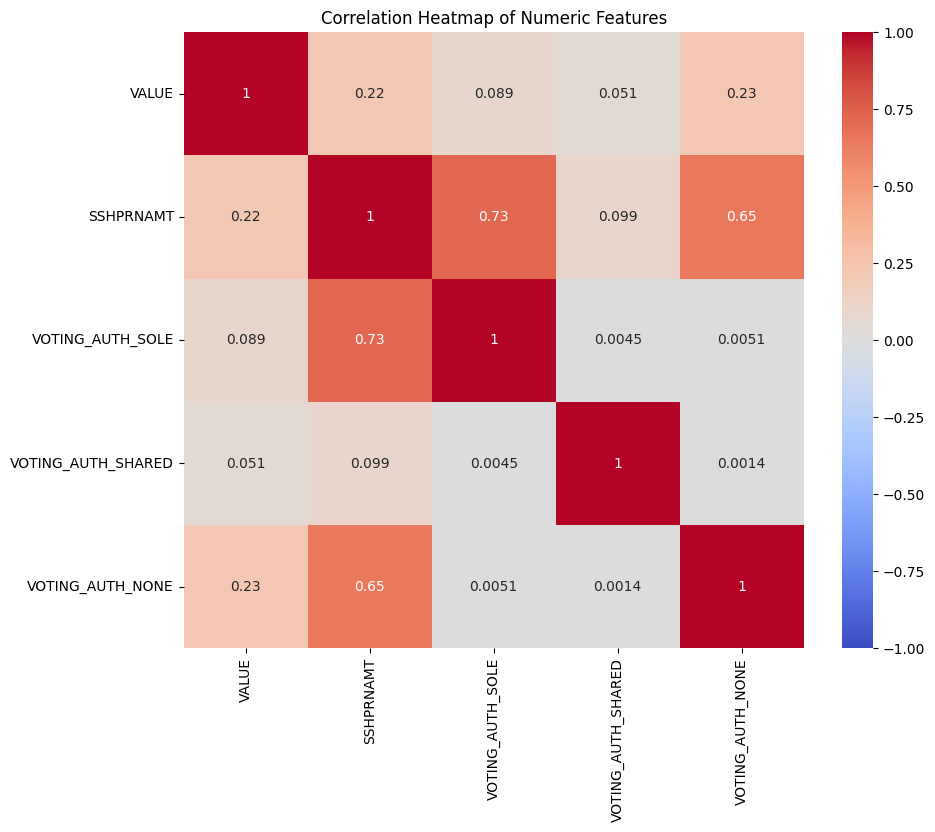

In [17]:
numeric_features = ['VALUE', 'SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']

plt.figure(figsize=(10, 8))
sns.heatmap(infotable_dataset[numeric_features].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Below is a more detailed description of each column:

### `INFOTABLE`

- `ACCESSION_NUMBER`: Unique identifier assigned by the SEC to each EDGAR submission.
- `INFOTABLE_SK`: Infotable surrogate key.
- `NAMEOFISSUER`: Name of issuer.
- `TITLEOFCLASS`: Title of class.
- `CUSIP`: CUSIP number of security.
- `FIGI`: Financial Instrument Global Identiﬁer (FIGI)
- `VALUE`: Market value. Starting on January 3, 2023, market value is reported rounded to the nearest dollar. Previously, market value was reported in thousands.
- `SSHPRNAMT`: Number of shares or principal amount.
- `SSHPRNAMTTYPE`: Shares (SH) or principal amount (PRN) type.
- `PUTCALL`: Put/call
- `INVESTMENTDISCRETION`: Investment discretion.
- `OTHERMANAGER`: Sequence number of other manager included in report with whom discretion is shared.
- `VOTING_AUTH_SOLE`: Voting authority sole.
- `VOTING_AUTH_SHARED`: Voting authority shared.
- `VOTING_AUTH_NONE`: Voting authority none.




## 1: Missing Values

In [18]:
print(f"Infotable has {len(infotable_dataset)} rows.")


Infotable has 5610507 rows.


Clearly, a large number of columns in the `COVERPAGE` table have missing values. This is not surprising, as not all columns are required to be filled out by the filer. For example, the `AMENDMENTNO` column is only filled out if the `ISAMENDMENT` column is checked. In our data analysis, the only columns that we may use are `ACCESSION_NUMBER`, `REPORTCALENDARORQUARTER`, and `ISAMENDMENT`. Therefore, we can replace missing values in `ISAMENDMENT` with `N` and missing values in `AMENDMENTNO` with `0`.

### `INFOTABLE`

In [19]:
print("Number of missing values in each column of the infotable:")
print(infotable_dataset.isna().sum())

Number of missing values in each column of the infotable:
investor                      0
INFOTABLE_SK                  0
NAMEOFISSUER                 80
TITLEOFCLASS                324
CUSIP                         0
FIGI                    5190030
VALUE                         0
SSHPRNAMT                     0
SSHPRNAMTTYPE                 0
PUTCALL                 5350644
INVESTMENTDISCRETION          0
OTHERMANAGER            3035085
VOTING_AUTH_SOLE              0
VOTING_AUTH_SHARED            0
VOTING_AUTH_NONE              0
timestamp                     0
dtype: int64


The columns `NAMEOFISSUER`, `TITLEOFCLASS`, `FIGI`, `PUTCALL`, and `OTHERMANAGER` have missing values. However, this will not be an issue. Note that `NAMEOFISSUER`, `TITLEOFCLASS`, and `FIGI` can be used to identifier the specific security, but this is unnecessary because the securities can be uniquely identified using the `CUSIP`. 

The `PUTCALL` column has many missing values, but these are easily filled in. If the value is missing, we can assume that the security is neither a put nor a call, but instead owned outright.

`OTHERMANAGER` has missing values, but this is not an issue. This column is only used when the investment discretion is shared with another manager. If the value is missing, then the investment discretion is not shared. 

In [12]:
infotable_dataset['PUTCALL'] = infotable_dataset['PUTCALL'].fillna('N/A')
infotable_dataset['OTHERMANAGER'] = infotable_dataset['OTHERMANAGER'].fillna('N/A')

The only column with missing values is `ISCONFIDENTIALOMITTED`. This column is a boolean column that indicates whether the data is confidential. If the value is missing, we can assume that the data is not confidential.

## Data Imbalance


### Potential Resolution for Data Imbalance Issue

Data imbalance can affect the performance of models, especially if the minority class is of particular interest. Below are two potential approaches we may consider to address this challenge before the next milestone:

1. **Stratified Cross-Validation**  
   Stratified cross-validation helps ensure that each fold of the training data has the same distribution of classes as the entire dataset. This approach allows our model to get a balanced representation during training, minimizing bias toward the majority class and improving the model's generalization on unseen data.

2. **Model Sensitivity to Minority Class**  
   By making our model more sensitive to the minority class, we can address the imbalance more effectively. This can be achieved by assigning a higher penalty for incorrect predictions on the minority class. In practice, this often involves adjusting class weights in the loss function, so that the model places more importance on correctly classifying instances from the minority class. This way, we aim to improve the recall of the minority class without significantly compromising overall accuracy.

These techniques can help us handle class imbalance in a way that improves the model's robustness and ensures it performs well on all classes.

### Data Scaling and Its Importance

**Data Scaling** is a critical preprocessing step in improving model performance and avoiding bias in machine learning tasks. In our project, we have features with varying ranges, and without scaling, features with larger scales could disproportionately influence the model. 

Our dataset includes features with varying numeric ranges (e.g., `VALUE`, `SSHPRNAMT`, and `VOTING_AUTH_*` columns). Without scaling, these features with larger values could overshadow features with smaller values, potentially skewing the results. This disparity could also hinder model convergence and reduce the effectiveness of model training.

To address these scaling differences, we have chosen **Standardization** as our primary technique, which centers data by subtracting the mean and dividing by the standard deviation. Standardization is especially suitable for datasets with normally distributed features, helping the model process all features on a comparable scale.

This could result in skewed analysis and inaccurate conclusions. Hence, it is essential to apply scaling techniques such as **Standardization** to bring all numeric features to a comparable scale, which ensures fair weighting across features and enhances interpretability.

In our dataset, we will focus on scaling the following numeric features:
- `VALUE`
- `SSHPRNAMT`
- `VOTING_AUTH_SOLE`
- `VOTING_AUTH_SHARED`
- `VOTING_AUTH_NONE`

We plan to approach scaling differently based on whether we are using **Time Series Cross-Validation** or not.

### Scaling Without Time Series Cross-Validation

Since we currently only have data for one quarter, there is no temporal pattern or chronological dependency to consider. This allows us to perform **Standardization** (Z-score scaling) across the entire dataset for this quarter without introducing bias from future data. Standardization transforms each feature to have a mean of 0 and a standard deviation of 1, making the scale of all features comparable.

In [ ]:
numeric_features = ['VALUE', 'SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']

scaler = StandardScaler()

infotable_dataset_standardized = infotable_dataset.copy()
infotable_dataset_standardized[numeric_features] = scaler.fit_transform(infotable_dataset[numeric_features])

print(infotable_dataset_standardized[numeric_features].head())

      VALUE  SSHPRNAMT  VOTING_AUTH_SOLE  VOTING_AUTH_SHARED  VOTING_AUTH_NONE
0 -0.037204  -0.030747         -0.020773           -0.023223         -0.033427
1  0.102095   0.007433          0.016028           -0.023223         -0.024865
2 -0.020869  -0.030730         -0.020840           -0.023223         -0.033099
3 -0.035241  -0.030049         -0.020258           -0.023223         -0.032656
4 -0.040602  -0.031320         -0.021486           -0.023223         -0.032929


### Problem Statement

The task involves predicting the **total value of assets held by institutional investors** based on specific features related to individual holdings. The problem is framed as a regression problem, with the following objectives:

- **Goal**: To develop a predictive model that estimates the total value (`VALUE`) of an investor's holdings using features such as:
  - Number of shares held (`SSHPRNAMT`).
  - Voting authority metrics (`VOTING_AUTH_SOLE`, `VOTING_AUTH_SHARED`, `VOTING_AUTH_NONE`).
- **Dataset Structure**:
  - The dataset includes quarterly data over multiple years, with a timestamp for each record.
  - Features include categorical information (e.g., `TITLEOFCLASS`, `CUSIP`), numerical data (e.g., `VALUE`, `SSHPRNAMT`), and timestamps.
  - Missing values in specific columns are handled through imputation or categorical assignment.
- **Challenges**:
  - Avoiding **data leakage** when using multiple time periods for modeling.
  - Ensuring that predictions are unbiased and do not rely on future data during training.
- **Key Requirements**:
  - Proper handling of time-series data to maintain chronological order during model training and evaluation.
  - Use of **Time Series Cross-Validation** to ensure the model's robustness and reliability across different time periods.
  - Scaling features within each fold of cross-validation to prevent information from leaking between training and testing datasets.


In [ ]:
features = ['SSHPRNAMT', 'VOTING_AUTH_SOLE', 'VOTING_AUTH_SHARED', 'VOTING_AUTH_NONE']
target = 'VALUE'

infotable_dataset = infotable_dataset.dropna(subset=[target]).sort_values(by='timestamp')

X = infotable_dataset[features].values
y = infotable_dataset[target].values

print("Dataset is prepared and sorted by timestamp.")
print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")

Dataset is prepared and sorted by timestamp.
Shape of feature matrix X: (5610507, 4)
Shape of target vector y: (5610507,)


### Scaling With Time Series Cross-Validation

As we move to the next milestone, we plan to add multiple quarters over 5+ years to create a comprehensive dataset with chronological data. When using this data for **Time Series Cross-Validation**, we must account for the temporal order to avoid data leakage, where future information might inadvertently influence the past. If we apply a global scaling approach across the whole dataset, it would incorporate information from future quarters, leading to optimistic results and bias.

To avoid this, we will apply **Standardization separately in each fold** of the cross-validation process. By standardizing data independently within each training fold, we ensure that each fold remains isolated from future information, preserving the temporal structure and yielding a more accurate evaluation.

In other words, as we expand to **multiple quarters in the next milestone**, applying global scaling across the dataset would cause **data leakage**, where future data influences past data, resulting in optimistic bias and unreliable evaluations. Instead, we will implement Standardization separately within each fold of the cross-validation process. This approach isolates the training and test data in each fold, ensuring future data does not impact past observations.

Below code implements **Time Series Cross-Validation** to evaluate a **Ridge Regression model** for predicting the total value of assets based on time-ordered data:

#### **Purpose**
- To evaluate the model's performance in a time-series setting while avoiding data leakage.
- Uses the **Ridge Regression** model, which helps handle multicollinearity by applying regularization to prevent overfitting.

---

#### **Steps**

1. **Define Time Series Cross-Validation**:
   - The `TimeSeriesSplit` method splits the dataset into sequential, non-overlapping folds, ensuring that training data always precedes test data.
   - `n_splits=5`: The data is divided into 5 folds, meaning there will be 5 rounds of training and testing. This approach respects the temporal order of the data.

2. **Initialize Ridge Regression Model**:
   - `Ridge(alpha=1.0)`: Ridge regression is chosen for its ability to manage collinear features, which is often the case in financial datasets.
   - `alpha=1.0`: This is the regularization strength. A higher alpha increases the penalty on large coefficients, reducing overfitting.

3. **Iterate Through Cross-Validation Folds**:
   - **Train-Test Split**:
     - `train_index` and `test_index`: Define the training and testing sets for each fold.
     - Training data always contains earlier timestamps, and testing data contains later timestamps, maintaining chronological order.

   - **Scaling**:
     - `StandardScaler`: Standardizes the features (mean = 0, standard deviation = 1) for each fold to avoid any bias from future data.
     - **Why?** Feature scaling is essential for Ridge Regression, as it penalizes coefficients, and unscaled features can lead to inconsistent penalties.

   - **Model Training**:
     - The Ridge Regression model is trained on the scaled training set (`X_train_scaled` and `y_train`).

   - **Prediction and Evaluation**:
     - The model predicts the target variable (`y_test`) on the test set (`X_test_scaled`).
     - Mean Squared Error (MSE) is computed to quantify the difference between predicted and actual values. Lower MSE indicates better performance.

4. **Store Metrics**:
   - The MSE for each fold is appended to `mse_scores`.
   - Results for each fold and overall metrics (mean and standard deviation of MSE) are displayed.

---

#### **Why Use Time Series Cross-Validation?**
- **Preserves Temporal Order**: Ensures that future data does not influence past data during training, avoiding unrealistic model evaluation (data leakage).
- **Simulates Real-World Scenarios**: Reflects how a model would perform when predicting future data based on historical data.

---

#### **Why Ridge Regression?**
- **Handles Multicollinearity**: Ridge is well-suited for datasets with correlated features, which is common in financial datasets.
- **Regularization**: The `alpha` parameter controls the penalty on large coefficients, helping prevent overfitting.

---

#### **Tuning/Parameters**
- **Ridge Alpha (Regularization Strength)**:
  - `alpha=1.0` is a moderate penalty. Larger values increase regularization, while smaller values reduce it.
  - Alpha tuning can be done using grid search or cross-validation to find the best trade-off between bias and variance.

- **Number of Splits (n_splits)**:
  - `n_splits=5` balances the need for multiple evaluations and maintaining sufficient data in the training set.

---

#### **Summary of Model Choice**
- A **Ridge Regression** model is used due to its robustness in handling multicollinear data.
- **Time Series Cross-Validation** ensures the temporal integrity of the data and provides a realistic evaluation of the model's predictive power.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
ridge_model = Ridge(alpha=1.0)
mse_scores = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    print(f"Fold {fold + 1}: MSE = {mse:.4f}")

print("\nCross-Validation Completed.")
print(f"Mean MSE across folds: {np.mean(mse_scores):.4f}")
print(f"Standard Deviation of MSE: {np.std(mse_scores):.4f}")


Fold 1: MSE = 103940817931576672.0000
Fold 2: MSE = 2459909888397877248.0000
Fold 3: MSE = 237224355430462944.0000
Fold 4: MSE = 192691507134579136.0000
Fold 5: MSE = 54698027451869304.0000

Cross-Validation Completed.
Mean MSE across folds: 609692919269273088.0000
Standard Deviation of MSE: 927332773018706688.0000


### Interpretation of the Results

The model's performance, as evaluated using **Time Series Cross-Validation**, reveals the following insights in the context of predicting the total value of institutional investor holdings:

---

#### **1. High Variance in MSE Across Folds**
- The Mean Squared Error (MSE) ranges widely across the folds, from **5.47 × 10¹³** to **2.46 × 10¹⁵**.
- **Reason**:
  - This suggests variability in the model's performance across different time periods, indicating that the underlying relationships between features and target value may not be stable over time.
  - Possible causes include changes in market conditions, investor strategies, or external factors (e.g., economic events).

#### **2. Extremely Large MSE Values**
- The magnitude of the MSE values is very high, making it clear that the model struggles to predict the target value accurately.
- **Reason**:
  - This could be due to:
    - High variance in the dataset (e.g., large fluctuations in asset values).
    - Lack of important predictive features in the dataset.
    - Potential issues with scaling or preprocessing of features.

#### **3. High Standard Deviation of MSE**
- The standard deviation of the MSE is also very large (**9.27 × 10¹⁴**), showing inconsistency in the model's performance across folds.
- **Reason**:
  - Some time periods may contain more noise or anomalous data, making them harder to predict.
  - The model may not generalize well to unseen data, particularly if patterns shift significantly over time.

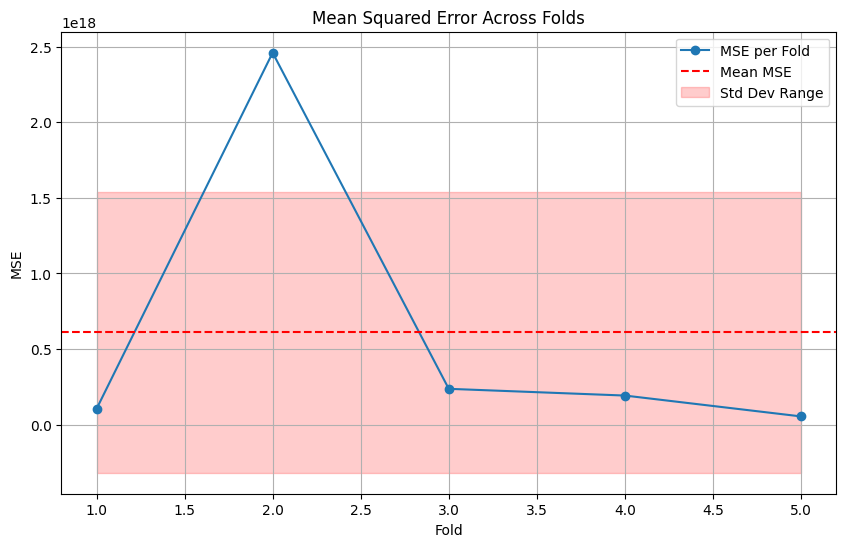

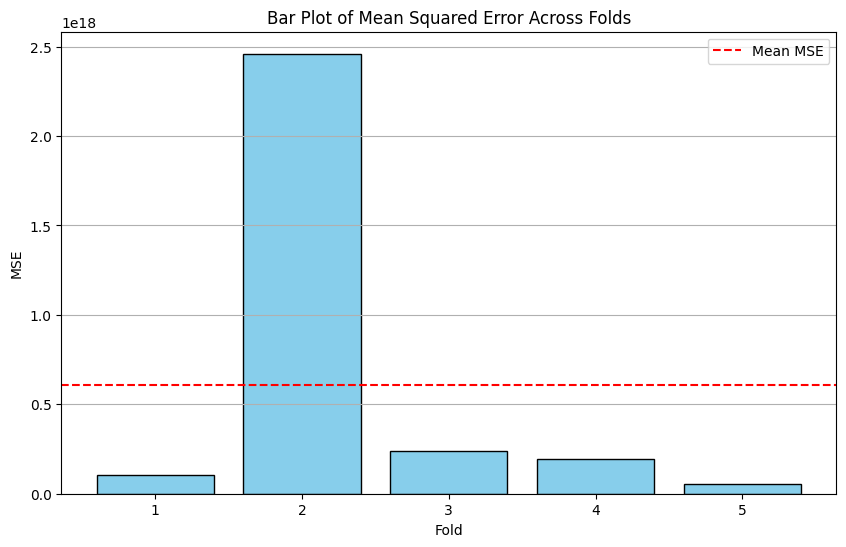

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', label='MSE per Fold')
plt.axhline(np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.fill_between(
    range(1, len(mse_scores) + 1),
    np.mean(mse_scores) - np.std(mse_scores),
    np.mean(mse_scores) + np.std(mse_scores),
    color='r',
    alpha=0.2,
    label='Std Dev Range'
)
plt.title('Mean Squared Error Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(mse_scores) + 1), mse_scores, color='skyblue', edgecolor='black')
plt.axhline(np.mean(mse_scores), color='r', linestyle='--', label='Mean MSE')
plt.title('Bar Plot of Mean Squared Error Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.legend()
plt.grid(axis='y')
plt.show()


#### **1. Mean Squared Error (MSE) Across Folds (Line Plot)**

- **What it shows**:
  - The MSE for each fold during cross-validation.
  - The red dashed line represents the mean MSE, while the shaded area indicates the standard deviation range.

- **Key Observations**:
  - Fold 2 exhibits an extremely high MSE compared to other folds, indicating a period where the model performed significantly worse.
  - Folds 1, 3, 4, and 5 show relatively lower MSE values, with some variability.
  - The variability in MSE (as shown by the standard deviation) suggests the model's performance is inconsistent across different time periods.

- **Reasoning**:
  - Fold 2 might represent a time period with anomalous or volatile market conditions, leading to poor predictions.
  - The inconsistency could also stem from missing features or a lack of temporal robustness in the model.

---

#### **2. MSE Across Folds (Bar Plot)**

- **What it shows**:
  - A bar chart representation of MSE for each fold, with the red dashed line showing the mean MSE.

- **Key Observations**:
  - Fold 2 has a disproportionately higher MSE than the other folds, dominating the overall mean.
  - The other folds have much smaller MSE values, highlighting Fold 2 as an outlier.

- **Reasoning**:
  - Fold 2 might represent a period where the relationship between features and target values deviates significantly from other periods, possibly due to external market disruptions or noise in the data.

In [ ]:
r2_scores = []
residuals = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    residuals.append(y_test - y_pred)

print("Additional Metrics Computed:")
print(f"R² Scores: {r2_scores}")


Additional Metrics Computed:
R² Scores: [-0.3150395103429431, -15.898844240660871, -0.051208086652109186, 0.09338225553094104, 0.04437305258778268]


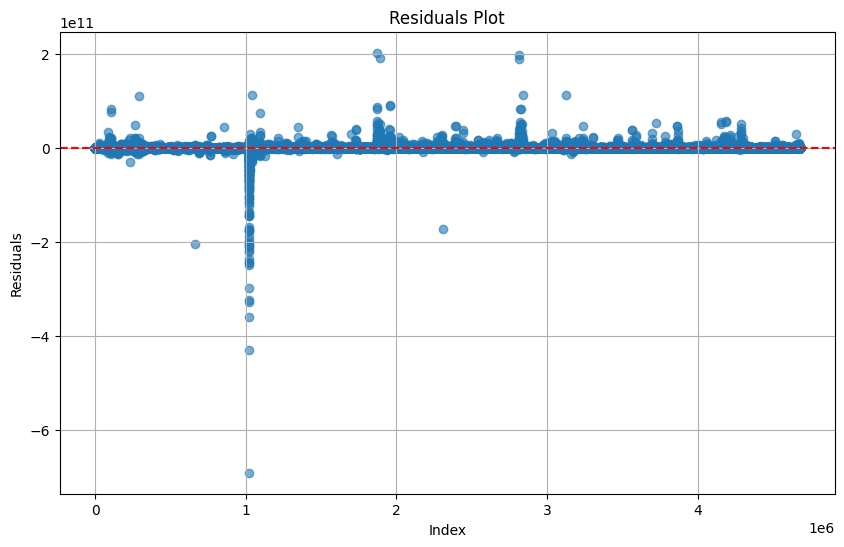

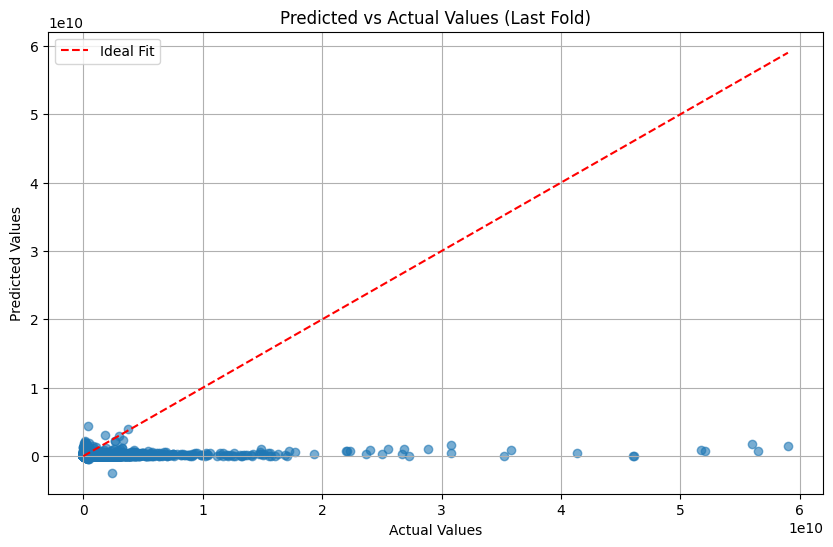

C:\Users\Aditya Saxena\AppData\Local\Temp\ipykernel_6744\4198094759.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals, labels=[f"Fold {i+1}" for i in range(len(residuals))])


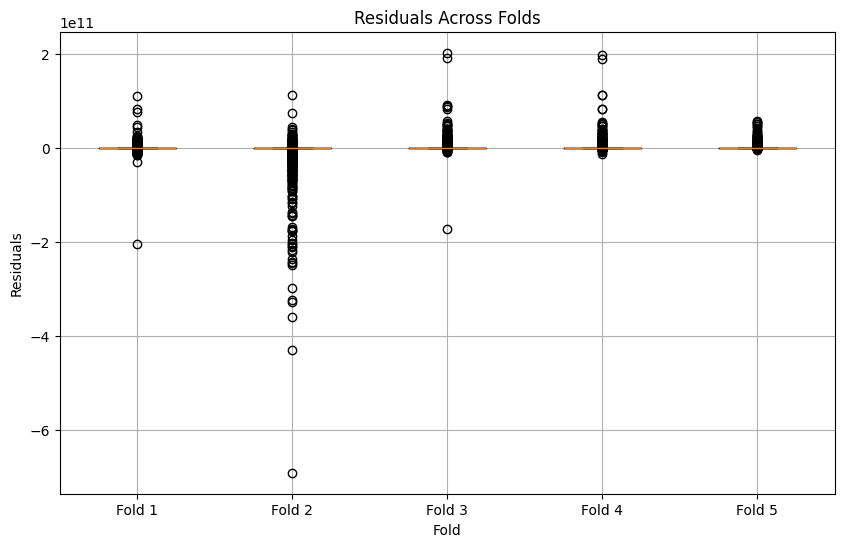

In [ ]:
all_residuals = np.concatenate(residuals)

# Residuals Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(all_residuals)), all_residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# Predicted vs Actual Plot (for the last fold)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.title("Predicted vs Actual Values (Last Fold)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

# Box Plot of Residuals Across Folds
plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=[f"Fold {i+1}" for i in range(len(residuals))])
plt.title("Residuals Across Folds")
plt.xlabel("Fold")
plt.ylabel("Residuals")
plt.grid()
plt.show()


#### **3. Residuals Plot**

- **What it shows**:
  - Residuals (difference between actual and predicted values) plotted against the index.
  - The red dashed line represents zero residuals (perfect predictions).

- **Key Observations**:
  - Residuals are widely scattered, with some extremely large positive and negative values.
  - There is a noticeable cluster of residuals far below zero, indicating significant underprediction in certain cases.

- **Reasoning**:
  - The large spread of residuals suggests the model struggles to capture the true relationships in the data, potentially due to unmodeled complexity or missing features.
  - Extreme negative residuals indicate specific cases where the model failed to predict accurately, possibly during highly volatile periods.

---

#### **4. Predicted vs Actual Values (Last Fold)**

- **What it shows**:
  - Predicted values plotted against actual values for the last fold.
  - The red dashed line represents the ideal fit (predicted = actual).

- **Key Observations**:
  - Most predicted values are clustered at the lower range, failing to match the higher actual values.
  - There is a clear underestimation of the target variable for larger actual values.

- **Reasoning**:
  - The model's bias toward underpredicting higher asset values suggests it cannot handle large variations in the data.
  - This could be due to insufficient regularization strength, a poor choice of model, or a lack of features capturing high-value trends.

---

#### **5. Residuals Across Folds (Box Plot)**

- **What it shows**:
  - Box plots of residuals for each fold, highlighting the spread and outliers in predictions.

- **Key Observations**:
  - All folds have wide residual distributions, with numerous outliers.
  - Fold 2 shows the largest spread and extreme outliers, consistent with its high MSE.

- **Reasoning**:
  - The wide spread indicates that the model struggles with consistent predictions across all folds.
  - The presence of many outliers suggests that certain data points are significantly mispredicted, likely due to missing key features or market anomalies.

---

### Summary of Findings

1. **Performance Variability**:
   - The model's performance is inconsistent across time periods, with Fold 2 standing out as a clear outlier.

2. **Prediction Challenges**:
   - The model underpredicts higher values, struggles with variability, and fails to capture complex relationships in the data.

3. **Model Limitations**:
   - Ridge Regression may not be the best choice for this dataset, as it appears too simplistic for the inherent complexity of financial data.

---

### Next Steps for Improvement

- **Feature Engineering**:
  - Include additional features that capture market trends, macroeconomic indicators, or sector-specific variables.

- **Model Exploration**:
  - Test more complex models, such as decision trees, random forests, or gradient boosting models, to capture non-linear relationships.

- **Hyperparameter Tuning**:
  - Experiment with different values for the `alpha` parameter in Ridge Regression or use grid search to find the optimal setting.

- **Address Anomalies**:
  - Investigate Fold 2 and other outliers to identify possible data quality issues or events causing the poor predictions.

